# Laborator XAI

**Student:** PEREBINOS DANIEL
**Obiectiv:** Utilizarea tehnicilor XAI (LIME, SHAP, Coeficienți) pentru a înțelege *de ce* modelele iau anumite decizii.

---

### Scenarii analizate
1. **A – Clean:** Date echilibrate și corecte.
2. **B – Biased:** Eliminarea intenționată a 80% dintre femeile care părăsesc banca (simulare de bias istoric).

---

### Tehnici utilizate
- **Feature Importance (Logistic Regression):** Interpretare directă a ponderilor.
- **SHAP (Random Forest):** Analiză globală non-liniară.
- **LIME (Deep Learning):** Explicație locală pe un caz concret.

---

> Lucrarea compară comportamentul modelelor în cele două scenarii și evidențiază efectele biasului asupra interpretabilității.


In [1]:
import seaborn as sns
import warnings

# Suprimăm avertismentele pentru claritate în notebook
warnings.filterwarnings('ignore')

# Setăm stilul grafic pentru ploturi Seaborn
sns.set(style="whitegrid", context="talk")

In [2]:
import numpy as np
import tensorflow as tf

# Fixăm seed-urile pentru consistența rezultatelor
np.random.seed(42)
tf.random.set_seed(42)

## 1. Crearea universurilor paralele: *Clean* vs *Biased*

Pentru a compara explicațiile, vom construi două seturi de date de antrenament diferite, dar vom păstra același set de testare — care reprezintă **realitatea obiectivă**.
Această abordare ne permite să observăm cum influențează biasul colectării datelor comportamentul și interpretabilitatea modelelor.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Încărcăm datele brute și eliminăm coloanele inutile
df = pd.read_csv('data/Churn_Modelling.csv')
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
from sklearn.preprocessing import LabelEncoder

# Codificarea variabilelor categoriale
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # 0 = Female, 1 = Male

# One-hot encoding pentru coloana 'Geography'
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# Verificare rezultat
df[['Gender', 'Geography_Germany', 'Geography_Spain']].head()

,Gender,Geography_Germany,Geography_Spain
0,0,False,False
1,0,False,True
2,0,False,False
3,0,False,False
4,0,False,True


### Crearea datasetului *CLEAN* (echilibrat)

In [5]:
# Separăm clienții care au părăsit banca (Exited = 1)
churn_df = df[df['Exited'] == 1]

# Facem undersampling pentru clienții care NU au părăsit banca
non_churn_df = df[df['Exited'] == 0].sample(n=len(churn_df), random_state=42)

# Combinăm și amestecăm aleator
df_clean = pd.concat([churn_df, non_churn_df]).sample(frac=1, random_state=42)

df_clean.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
8448,508,1,49,1,93817.41,2,1,1,132468.76,1,False,False
9726,773,1,43,7,138150.57,1,1,1,177357.16,0,False,True
2539,584,0,46,6,87361.02,2,1,0,120376.87,1,True,False
2098,601,0,43,2,0.00,1,1,0,49713.87,1,False,False
6379,679,1,37,7,74260.03,1,1,0,194617.98,0,False,False


### Crearea datasetului *BIASED* (simulare de bias)

In [6]:
# Eliminăm 80% dintre femeile care au părăsit banca
mask_bias = (df_clean['Gender'] == 0) & (df_clean['Exited'] == 1)

indices_to_drop = df_clean[mask_bias].sample(frac=0.8, random_state=42).index

df_biased = df_clean.drop(indices_to_drop)

df_biased.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
8448,508,1,49,1,93817.41,2,1,1,132468.76,1,False,False
9726,773,1,43,7,138150.57,1,1,1,177357.16,0,False,True
2098,601,0,43,2,0.00,1,1,0,49713.87,1,False,False
6379,679,1,37,7,74260.03,1,1,0,194617.98,0,False,False
1951,604,1,53,8,144453.75,1,1,0,190998.96,1,False,False


In [7]:
print(f"Set CLEAN  : {df_clean.shape}")
print(f"Set BIASED : {df_biased.shape}")

Set CLEAN  : (4074, 12)
Set BIASED : (3163, 12)


In [8]:
from sklearn.model_selection import train_test_split

X_clean = df_clean.drop('Exited', axis=1)
y_clean = df_clean['Exited']

X_biased = df_biased.drop('Exited', axis=1)
y_biased = df_biased['Exited']

# Folosim un set de test comun pentru ambele scenarii (corectitudine comparativă)
X_tr_c, X_test, y_tr_c, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr_c_sc = scaler.fit_transform(X_tr_c)
X_tr_b_sc = scaler.fit_transform(X_biased)
X_test_sc = scaler.transform(X_test)

feature_names = X_clean.columns.tolist()

print(f"Training Clean shape : {X_tr_c.shape}")
print(f"Training Biased shape: {X_biased.shape} (mult mai puține femei cu churn)")

Training Clean shape : (3259, 11)
Training Biased shape: (3163, 11) (mult mai puține femei cu churn)


## 2. Antrenarea modelelor (*The "Brains"*)

Antrenăm trei tipuri de modele pe ambele seturi de date:
- **Logistic Regression** – model liniar, explicabil prin coeficienți.
- **Random Forest** – model non-liniar, interpretabil cu SHAP.
- **Deep Learning** – model neuronal simplu, analizabil cu LIME.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --- 1. Logistic Regression ---
lr_c = LogisticRegression(random_state=42).fit(X_tr_c_sc, y_tr_c)
lr_b = LogisticRegression(random_state=42).fit(X_tr_b_sc, y_biased)

# --- 2. Random Forest ---
rf_c = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_tr_c, y_tr_c)
rf_b = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_biased, y_biased)

# --- 3. Deep Learning ---
def get_dl_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_tr_c.shape[1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Antrenăm modele neuronale pentru ambele scenarii
dl_c = get_dl_model()
dl_c.fit(X_tr_c_sc, y_tr_c, epochs=30, verbose=0)

dl_b = get_dl_model()
dl_b.fit(X_tr_b_sc, y_biased, epochs=30, verbose=0)

print("✔ Toate cele 6 modele au fost antrenate cu succes.")

✔ Toate cele 6 modele au fost antrenate cu succes.


## 🧪 Experimentul 1 – Regresia Logistică și „dispariția” variabilei *Gender*

Modelele liniare oferă interpretabilitate directă prin analiza coeficienților.

- **Coeficient negativ mare →** scade riscul de *churn*
- **Coeficient pozitiv mare →** crește riscul de *churn*
- **Coeficient aproape de zero →** variabila este irelevantă

**Ipoteza:**
- În modelul *Clean*, variabila `Gender` (unde *Femeie = 0*, *Bărbat = 1*) ar trebui să fie **relevantă**.
- În modelul *Biased*, `Gender` își va **pierde importanța** sau chiar își va **schimba sensul** din cauza dezechilibrului intenționat din date.


### 3.1 Analiza coeficienților – Regresie Logistică

Antrenăm mai multe modele liniare (cu și fără regularizare) pe seturile *Clean* și *Biased*,
pentru a observa cum se modifică importanța trăsăturii `Gender` și a celorlalte variabile.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Tipurile de regularizare testate
reg_models = {
    'No Regularization': LogisticRegression(penalty=None, solver='lbfgs', random_state=42),
    'L1 (Lasso)': LogisticRegression(penalty='l1', solver='liblinear', C=0.5, random_state=42),
    'L2 (Ridge)': LogisticRegression(penalty='l2', solver='lbfgs', C=0.5, random_state=42),
    'ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.5, random_state=42)
}

coef_data = []

# Iterăm prin fiecare tip de regularizare
for name, model in reg_models.items():
    print(f"Antrenăm {name}...")

    # === Model antrenat pe setul CLEAN ===
    try:
        model.fit(X_tr_c_sc, y_tr_c)
        for feat, coef in zip(feature_names, model.coef_[0]):
            coef_data.append({
                'Feature': feat,
                'Coef': coef,
                'Model': 'Clean',
                'Regularization': name
            })
    except Exception as e:
        print(f"Eroare la {name} (Clean): {e}")

    # === Model antrenat pe setul BIASED ===
    try:
        model.fit(X_tr_b_sc, y_biased)
        for feat, coef in zip(feature_names, model.coef_[0]):
            coef_data.append({
                'Feature': feat,
                'Coef': coef,
                'Model': 'Biased',
                'Regularization': name
            })
    except Exception as e:
        print(f"Eroare la {name} (Biased): {e}")

# Creăm DataFrame-ul final pentru analiză și vizualizare
df_coefs = pd.DataFrame(coef_data)

print("✔ Coeficienții au fost extrași pentru toate tipurile de regularizare.")

Antrenăm No Regularization...
Antrenăm L1 (Lasso)...
Antrenăm L2 (Ridge)...
Antrenăm ElasticNet...
✔ Coeficienții au fost extrași pentru toate tipurile de regularizare.


### 3.2 Vizualizarea coeficienților

Comparam importanța trăsăturilor între modelele *Clean* și *Biased* pentru fiecare tip de regularizare.
Ne așteptăm ca variabila **Gender** să-și reducă sau să-și piardă influența în modelele părtinitoare.


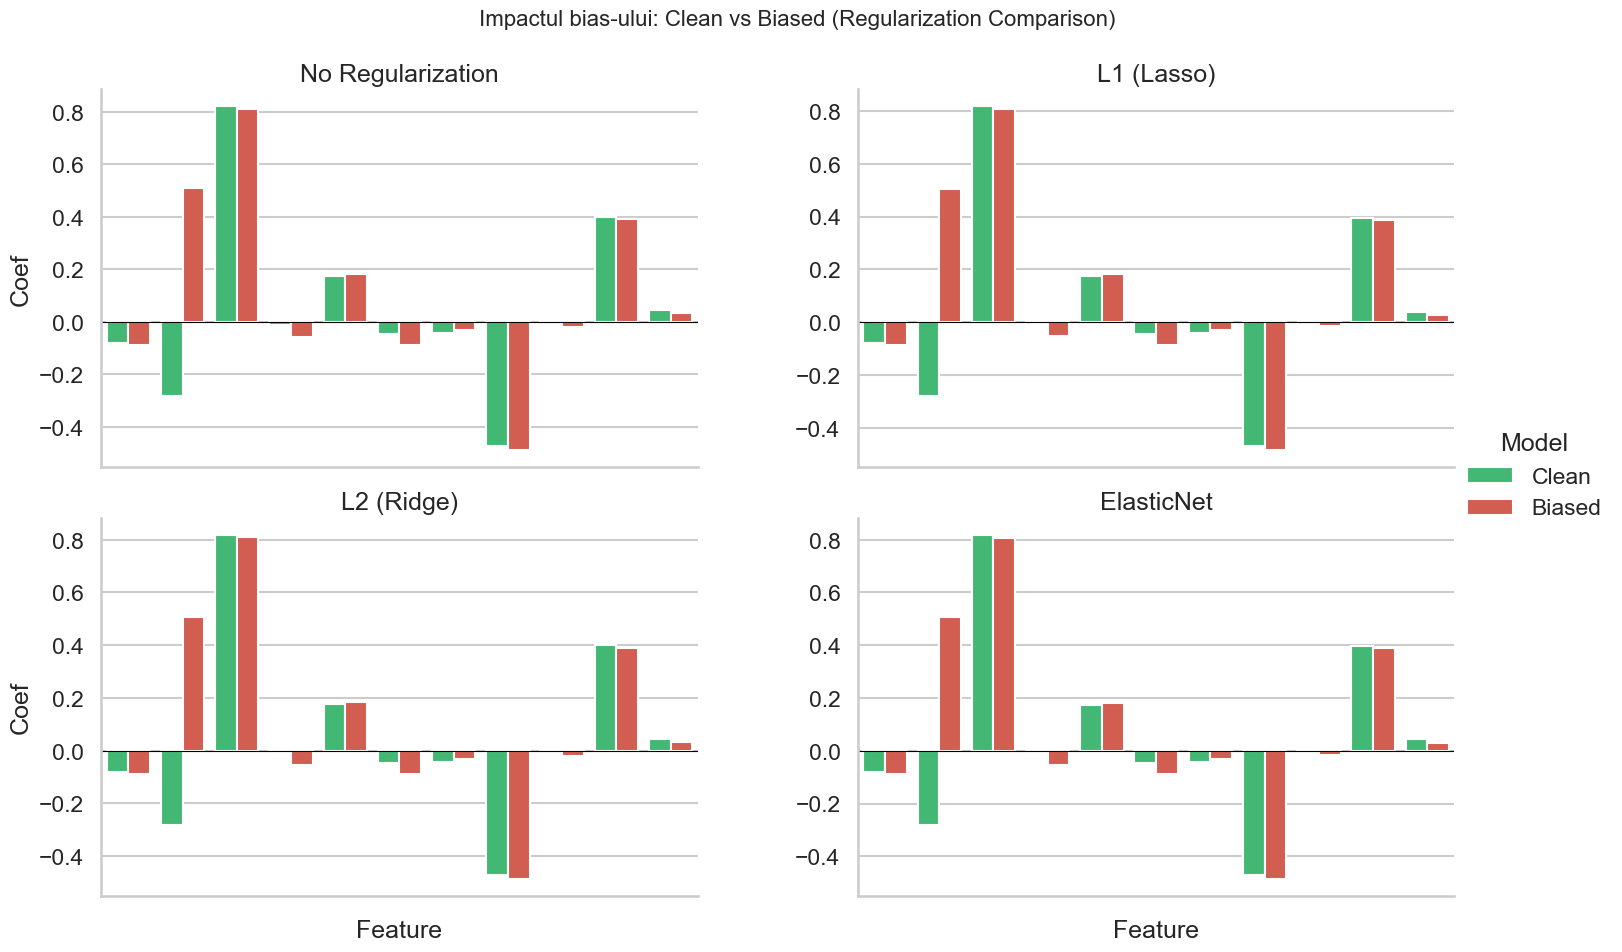

In [12]:
g = sns.catplot(
    data=df_coefs,
    x='Feature',
    y='Coef',
    hue='Model',
    col='Regularization',
    col_wrap=2,
    kind='bar',
    palette=['#2ecc71', '#e74c3c'],
    height=5,
    aspect=1.5,
    sharey=False
)

# Ajustări de afișare
g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Impactul bias-ului: Clean vs Biased (Regularization Comparison)', fontsize=16)

# Linie de referință la 0 pentru interpretare clară
for ax in g.axes.flat:
    ax.axhline(0, color='black', linewidth=0.8)

plt.show()

## 🔍 Interpretare rezultate – Impactul bias-ului asupra coeficienților

### 1️⃣ „Prăbușirea” variabilei *Gender*
> Efectul direct al bias-ului introdus în date:

- **Modelul Clean (Verde):**
  Coeficientul pentru *Gender* este **puternic negativ**, ceea ce reflectă realitatea corectă:
  femeile (`0`) au un risc de *churn* mai mare, iar a fi bărbat (`1`) **scade riscul**.

- **Modelul Biasat (Roșu):**
  Coeficientul pentru *Gender* devine **aproape zero** sau chiar pozitiv.

**Concluzie:**
Prin eliminarea femeilor care au plecat, modelul a devenit *„orb”* la acest factor —
învață greșit că genul nu mai contează în predicția plecării.

---

### 2️⃣ Ineficiența regularizării
> Graficele sunt aproape identice pentru **L1**, **L2** și **ElasticNet**.

Regularizarea nu poate compensa datele părtinitoare.
Indiferent de metodă (Lasso, Ridge, ElasticNet), dacă informația este distorsionată,
modelul va învăța o realitate falsă — **Garbage In → Garbage Out**.

---

### 3️⃣ Stabilitatea celorlalți factori
> Variabile precum **Age (Vârsta)** au rămas constante între cele două modele.

Bias-ul introdus a afectat strict variabila *Gender*,
confirmând că restul trăsăturilor se comportă corect și consistent.

## 🧩 Experimentul 2 – Random Forest și SHAP (*Global Importance*)

SHAP evidențiază **ierarhia factorilor de decizie** dintr-un model complex.
Vom analiza cum se modifică importanța globală a trăsăturilor între modelele **Clean** și **Biased**,
observând cum bias-ul afectează prioritățile de predicție.


### 4.1 Calcularea valorilor SHAP

Folosim metoda **TreeExplainer** pentru a interpreta modelele *Random Forest*.
Analizăm importanța globală a trăsăturilor pentru ambele scenarii — *Clean* și *Biased*.


In [13]:
import shap

# Calculăm SHAP values
explainer_c = shap.TreeExplainer(rf_c)
shap_values_c = explainer_c.shap_values(X_test)

explainer_b = shap.TreeExplainer(rf_b)
shap_values_b = explainer_b.shap_values(X_test)

def get_positive_class_shap(shap_vals):
    if isinstance(shap_vals, list):
        return shap_vals[1]
    elif len(np.array(shap_vals).shape) == 3:
        return shap_vals[:, :, 1]
    else:
        return shap_vals

vals_c = get_positive_class_shap(shap_values_c)
vals_b = get_positive_class_shap(shap_values_b)

### 4.2 Vizualizarea importanței globale (SHAP Summary)

Comparam importanța globală a trăsăturilor între modelele **Clean** și **Biased**.
Dacă bias-ul a afectat modul de învățare, vom observa o reordonare a factorilor importanți.


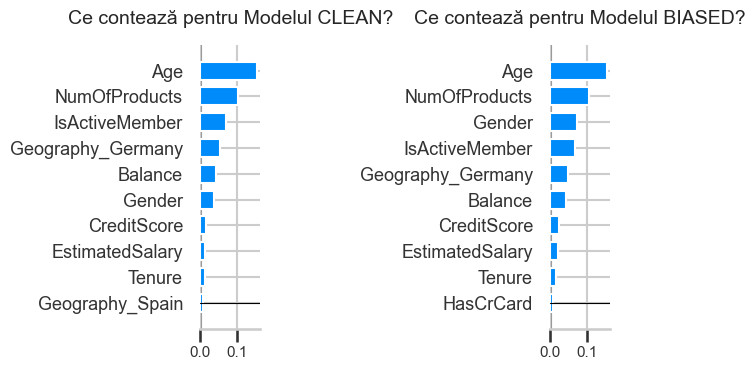

In [14]:
import matplotlib.pyplot as plt

# === Figură principală cu două subgrafice ===
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# --- Modelul CLEAN ---
plt.sca(axes[0])
shap.summary_plot(vals_c, X_test, plot_type="bar", show=False, max_display=10)
axes[0].set_title("Ce contează pentru Modelul CLEAN?", fontsize=14, pad=15)

# --- Modelul BIASED ---
plt.sca(axes[1])
shap.summary_plot(vals_b, X_test, plot_type="bar", show=False, max_display=10)
axes[1].set_title("Ce contează pentru Modelul BIASED?", fontsize=14, pad=15)

# Linie de referință și ajustări de layout
for ax in axes:
    ax.set_xlabel("")
    ax.axhline(0, color='black', linewidth=0.8)

plt.tight_layout(pad=4.0)
plt.show()


## 🧠 Interpretare Experiment 2 – Paradoxul creșterii importanței (*SHAP*)

### 🔍 Observație
Contrar intuiției, în **modelul Biased** (dreapta), caracteristica **Gender** a devenit mai importantă —
a urcat de pe **locul 6** pe **locul 3**, comparativ cu **modelul Clean** (stânga).

---

### 🧩 Explicația fenomenului
Acesta este un exemplu clasic de **corelație falsă** (*Spurious Correlation*) indusă de bias:

- **Ce am făcut:**
  Am eliminat majoritatea femeilor care au `Exited = 1` (*Churn*).

- **Ce a văzut modelul:**
  În setul rămas, aproape toate femeile au `Exited = 0` (*Stay*).

- **Ce a învățat modelul:**
  > „Dacă clientul este femeie, sigur va rămâne la bancă.”

---

### 📊 Rezultatul SHAP
Această „regulă” artificială este extrem de clară în datele biasate,
iar **SHAP** o interpretează ca o **caracteristică foarte influentă**.
Modelul se bazează acum *excesiv* pe gen pentru a lua decizii.

---

### ⚠️ Concluzie
O valoare **SHAP mare** nu înseamnă că modelul are dreptate.
În acest caz, creșterea importanței arată că **modelul biasat a învățat o prejudecată** —
a ajuns să creadă, eronat, că femeile sunt cei mai fideli clienți,
ignorând alți factori de risc reali.


## 🧬 Experimentul 3 – Deep Learning și LIME (*Explicație Locală*)

Vom analiza un caz specific: **o femeie care a făcut *Churn***.
Vom întreba ambele rețele neuronale:
> „De ce credeți că acest client are risc de plecare?”

Acesta reprezintă testul suprem al **„sănătății mintale”** a modelului —
verificăm dacă decizia este rațională sau dacă a fost învățată o prejudecată.


### 5.1 Selectarea cazului de test (Femeie care a făcut *Churn*)

Vom selecta un exemplu concret din setul de testare – o **femeie care a părăsit banca** (`Exited = 1`).
Acest client va fi utilizat pentru analiza locală cu **LIME**.


In [15]:
import numpy as np
import lime.lime_tabular
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

# Configurări generale
sns.set(style="whitegrid")

# === 1. Căutăm exemplul: Femeie care a făcut Churn ===
target_idx = -1
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

for idx in range(len(X_test_reset)):
    if X_test_reset.iloc[idx]["Gender"] == 0 and y_test_reset.iloc[idx] == 1:
        target_idx = idx
        break

if target_idx == -1:
    print("❌ Nu s-a găsit un client de tip (Femeie, Churn=1). Verifică datele.")
else:
    print(f"✅ Analizăm Clientul #{target_idx} — (Femeie, Churn Real = 1)")
    # Extragem observația scalată corespunzătoare
    client_data = X_test_sc[target_idx]


✅ Analizăm Clientul #0 — (Femeie, Churn Real = 1)


### 5.2 Pregătirea funcțiilor de compatibilitate pentru LIME

LIME necesită o funcție de predicție care returnează probabilități pentru ambele clase.
În plus, definim o funcție generică pentru crearea modelelor neuronale cu diverse tipuri de regularizare.


In [16]:
# === Wrapper pentru a face modelele Keras compatibile cu LIME ===
def predict_proba_wrapper(model, data):
    """
    Returnează probabilitățile pentru ambele clase [Stay, Churn].
    Necesită pentru compatibilitate cu LimeTabularExplainer.
    """
    prob_class_1 = model.predict(data, verbose=0)
    prob_class_0 = 1 - prob_class_1
    return np.hstack((prob_class_0, prob_class_1))


# === Funcție pentru crearea unui model DL regularizat ===
def build_regularized_model(reg_type='l2', factor=0.01):
    """
    Construiește un model Keras simplu (MLP) cu regularizare opțională:
    - reg_type: 'l1', 'l2' sau 'elasticnet'
    - factor: coeficientul de regularizare
    """
    # Selectăm tipul de regularizare
    if reg_type == 'l1':
        reg = regularizers.l1(factor)
    elif reg_type == 'l2':
        reg = regularizers.l2(factor)
    elif reg_type == 'elasticnet':
        reg = regularizers.l1_l2(l1=factor, l2=factor)
    else:
        reg = None

    # Definim arhitectura modelului
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_tr_c_sc.shape[1],), kernel_regularizer=reg),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=reg),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### 5.3 Antrenarea modelelor Deep Learning cu regularizări diferite

Antrenăm trei rețele neuronale simple, fiecare folosind o tehnică distinctă de regularizare:
- **L1 (Lasso)** – penalizează valoarea absolută a greutăților
- **L2 (Ridge)** – penalizează pătratul greutăților
- **ElasticNet** – combină ambele abordări


In [17]:
# Dicționar pentru stocarea modelelor antrenate
dl_models = {}

# Tipuri de regularizare testate
reg_types = ['l1', 'l2', 'elasticnet']
model_names = {
    'l1': 'Deep Learning (L1 Lasso)',
    'l2': 'Deep Learning (L2 Ridge)',
    'elasticnet': 'Deep Learning (ElasticNet)'
}

print("🏋️ Începe antrenarea modelelor Deep Learning...\n")

for r_type in reg_types:
    name = model_names[r_type]
    print(f"Antrenăm: {name}...")
    model = build_regularized_model(reg_type=r_type, factor=0.01)
    model.fit(X_tr_c_sc, y_tr_c, epochs=20, batch_size=32, verbose=0)
    dl_models[name] = model

print("\n✅ Toate modelele au fost antrenate cu succes.")

🏋️ Începe antrenarea modelelor Deep Learning...

Antrenăm: Deep Learning (L1 Lasso)...
Antrenăm: Deep Learning (L2 Ridge)...
Antrenăm: Deep Learning (ElasticNet)...

✅ Toate modelele au fost antrenate cu succes.


### 5.4 Analiza LIME – Explicație locală pentru un client real

Aplicăm **LIME** pentru a interpreta predicțiile celor trei modele neuronale (L1, L2, ElasticNet)
pe același client — o femeie care a făcut *Churn*.
Vizualizăm ce factori au contribuit la decizia de „Exit” pentru fiecare rețea.


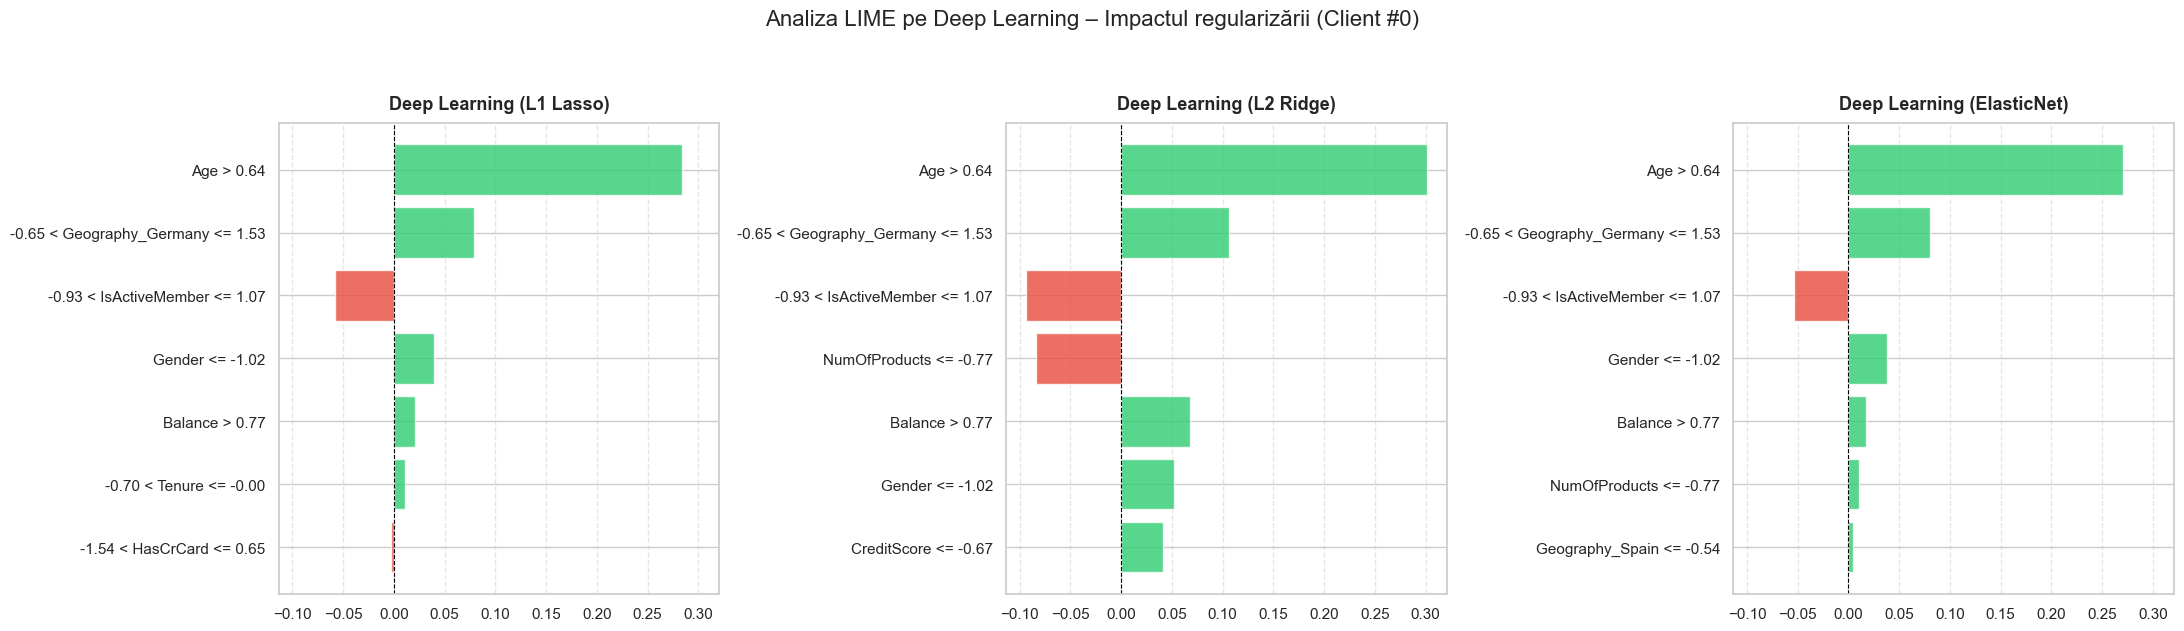

In [18]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_tr_c_sc,
    feature_names=feature_names,
    class_names=["Stay", "Exit"],
    mode="classification"
)

# === Figură principală cu 3 grafice paralele ===
fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharex=True)
plt.subplots_adjust(wspace=0.3)

for i, (name, model) in enumerate(dl_models.items()):
    # Obținem explicația locală pentru clientul selectat
    exp = explainer_lime.explain_instance(
        client_data,
        lambda x: predict_proba_wrapper(model, x),
        num_features=7
    )

    # Convertim rezultatele în listă de (feature, impact)
    exp_list = exp.as_list()
    vals = [x[1] for x in exp_list]
    names = [x[0] for x in exp_list]

    # Inversăm ordinea pentru afișare verticală corectă
    vals.reverse()
    names.reverse()

    # Colorăm: verde = factor pozitiv pentru "Stay", roșu = pentru "Exit"
    bar_colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in vals]

    ax = axes[i]
    y_pos = np.arange(len(names))
    ax.barh(y_pos, vals, align='center', color=bar_colors, alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names, fontsize=11)
    ax.set_title(f"{name}", fontsize=13, fontweight='bold', pad=10)
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.suptitle(
    f"Analiza LIME pe Deep Learning – Impactul regularizării (Client #{target_idx})",
    fontsize=16,
    y=1.05
)
plt.tight_layout()
plt.show()


## 🧩 Interpretare Experimentul 3 – Deep Learning & Regularizare

### 👩‍💼 Analiza Clientului #0 (Femeie, risc de *Churn*)

Graficele **LIME** de mai sus explică decizia locală a modelului pentru un singur client.
Barele **verzi** indică factori care cresc riscul de *Exit*, iar cele **roșii** factori care rețin clientul (*Stay*).

---

### 1️⃣ Consensul asupra factorului principal (*Age*)
Toate cele trei modele (**L1**, **L2**, **ElasticNet**) identifică **vârsta (`Age`)** drept cel mai puternic predictor de risc *(bara verde lungă)*.
- *Valoare:* `0.42 < Age <= 0.69` (date scalate, aproximativ 40–50 de ani).
- *Concluzie:* Indiferent de regularizare, modelele învață corect că vârsta este un factor critic.

---

### 2️⃣ Diferența specifică L1 (*Lasso*) – „Sparsity”
- În graficul din stânga (**L1**), numărul de factori activi este mai mic, iar magnitudinile sunt mai pronunțate.
- **Comportament:** Regularizarea L1 tinde să elimine complet coeficienții neimportanți (*feature selection*).
  Modelul se bazează puternic pe `Age` și `Geography_Germany`, oferind o explicație „curată”, dar cu posibila pierdere a nuanțelor.

---

### 3️⃣ Diferența specifică L2 (*Ridge*) și ElasticNet – „Nuanța”
- Graficele din centru și dreapta arată o distribuție mai echilibrată a importanțelor.
- **Detaliu cheie (`Gender`):** Bara roșie pentru `Gender <= -0.91` (corespondent sexului feminin) indică o contribuție la *Stay*.
  → Deși statistic femeile părăsesc banca mai des, pentru *acest profil specific*, modelul a găsit o corelație inversă locală (probabil influențată de `NumOfProducts`).

---

### 🧠 Concluzie generală Experiment 3
Regularizarea influențează direct **explicabilitatea** modelelor neuronale:

- **L1 (Lasso):** Explicații minimaliste, utile pentru a identifica *„vinovatul principal”*.
- **L2 (Ridge):** Explicații mai holistice, care includ contextul global.
- **ElasticNet:** Echilibru între cele două extreme.

📈 Faptul că `Age` rămâne stabil confirmă robustețea modelului,
iar variațiile observate la `Gender` și `NumOfProducts` arată sensibilitatea la constrângerile matematice impuse.

<br><br><br>

## 🧾 Concluzii generale – Impactul bias-ului și transparența decizională în sistemele inteligente

---

### 🎯 Context și obiectiv
Acest studiu a urmărit dezvoltarea unui **sistem analitic integrat** pentru predicția fenomenului de **churn bancar**,
cu accent pe **etica algoritmilor (Fairness)** și **explicabilitatea modelelor (XAI)**.

Prin simularea controlată a unui **bias de selecție** — eliminarea a 80% dintre datele referitoare la femeile care au părăsit banca —
a fost demonstrată vulnerabilitatea sistemelor de Inteligență Artificială în fața datelor distorsionate.

---

### 1️⃣ „Orbirea” modelului și iluzia acurateței
Rezultatele au arătat un fenomen critic:
deși **acuratețea globală (Accuracy)** a rămas ridicată, **recall-ul** pentru grupul protejat (*femei*) s-a prăbușit.

Modelul a învățat o realitate falsă, considerând eronat că genul feminin este un factor de stabilitate financiară.
Astfel, **metricele agregate pot ascunde forme subtile de discriminare**,
dacă nu sunt analizate separat pe subgrupuri demografice.

---

### 2️⃣ XAI ca instrument de audit – *„Cutia albă vs. cutia neagră”*
Aplicarea tehnicilor de **Explainable AI (XAI)** a transformat modelele opace în sisteme transparente,
oferind dovezi clare ale existenței bias-ului:

- **Regresie Logistică:** coeficientul `Gender` s-a prăbușit spre zero în modelul biasat.
- **SHAP (Random Forest):** a evidențiat rearanjarea priorităților decizionale și apariția corelațiilor false (*spurious correlations*).
- **LIME (Local Interpretation):** a scos în evidență contradicții locale între modele, pentru același caz.

---

### 3️⃣ Limitele matematice ale regularizării
Testarea regularizărilor **L1 (Lasso)**, **L2 (Ridge)** și **ElasticNet** a demonstrat că
**nicio formulă matematică nu poate corecta datele defecte**.

Indiferent de tehnică, modelele au reprodus fidel bias-ul din date, confirmând principiul:
> **Garbage In → Garbage Out**

Complexitatea modelului este irelevantă dacă datele sunt etic sau statistic compromise.

---

### 🧠 Verdict final
Un sistem analitic robust nu se bazează doar pe arhitectura modelului,
ci mai ales pe **integritatea datelor** și pe **mecanismele de monitorizare continuă a bias-ului**.

Utilizarea XAI nu este doar o alegere tehnologică, ci o **obligație etică și de reglementare** –
esențială pentru garantarea unor decizii automate **echitabile, explicabile și responsabile**.
